## 1. Simulation
Simulate the process of magnetization based on 2D Ising model, assume no external magnetic field. Use Metroplolis Algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

### Description of process
Consider a set $\Lambda$ of lattice sites in 2D, each site $i$ has a spin $\sigma_i\in\{-1,+1\}$. For each adjacent site $i,j$ there is an interaction $J_{ij}$ between them. Assume interaction strength is the same everywhere in the lattice, and hence $J_{ij}=J$. Consider only energy in the links between the nearest 4 neighbors. Without external magnetic field, the energy of a specific configuration $\underline{\sigma}=\{\sigma_1, ..., \sigma_N\}$ is therefore:

$E(\underline{\sigma}) = -\sum_{<i,j>}{J\sigma_i\sigma_j}$

Where $<i,j>$ denotes sum over all the adjacent neighbors $i,j$. This formualtion favours alignment between sites (i.e. lower energy when sites are aligned).

The Boltzmann distribution describes the probability of configuration $\underline{\sigma}$ as:

$p_{\beta}(\underline{\sigma}) = \frac{e^{-\beta E(\underline{\sigma})}}{Z_{\beta}}$

Where $\beta = 1/(k_B T)$ is the inverse of temperature.

#### The metropolis algorithm:
This algorithm evolves the system to equilibrium:
1. start with a square NxN lattice
2. randomly choose a site i, now we need to decide wether or not the flip the spin of this site. Let initial energy be E_i and the energy of the flipped state be E_f.
3. if E_i>E_f, flipping results in a lower energy state, hence flip spin(i)
4. if E_i<E_f, the site still has some probability $e^{-\beta(E_f-E_i)}$ of flipping the spin
5. repeat the process from 1

In [2]:
def initialise(N, bias=0.5, seed=0):
    ''' randomly initialise an N*N matrix with {-1,+1}. Bias is the probability of up spins.'''
    np.random.seed(seed)
    config = np.random.choice([1, -1], size=(N, N), p=[bias, 1-bias])
    return config

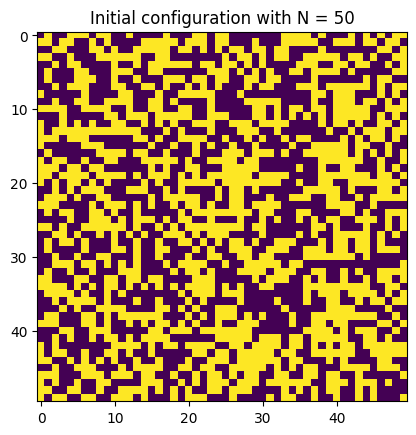

In [37]:
# visualise initial lattice, yellow = +1
N = 50
lattice = initialise(N, bias=0.5, seed=10)
plt.imshow(lattice);
plt.title(f'Initial configuration with N = {N}');

In [4]:
def get_energy(lattice):
    # applies the nearest neighbours summation, assumes J=1
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # total energy should be divided by 2 as each of the neighboring <i,j> pair contributed once to the energy
    return arr.sum()/2

In [5]:
get_energy(lattice)

-110.0

In [6]:
def get_magnetisation(lattice):
    # average spin
    return lattice.sum()/lattice.size

In [7]:
get_magnetisation(lattice)

0.0182

In [8]:
@numba.njit("UniTuple(f8[:], 5)(i8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(lattice, time, BJ, energy):
    ''' Perform flip on one random site each time '''
    N = lattice.shape[0]

    # save energies and magnetisation for checking
    energies = np.zeros(time)
    magnetisations = np.zeros(time)
    
    # save values for perception-action loop
    S = np.zeros(time) # sensory values at time t, sum of sigma_i*sigma_j for four neighbours
    A = np.zeros(time) # actions at time t
    SNext = np.zeros(time) # sensory values at time t+1, sum of sigma_i*sigma_j for four neighbours

    for t in range(time):
        energies[t] = energy
        magnetisations[t] = lattice.sum()/lattice.size
        
        # at each time step, randomly choose a site, compute energy before and after flipping
        x,y = np.random.randint(N), np.random.randint(N)
        spin_i = lattice[x][y] # initial spin
        spin_f = -1*spin_i # spin after flipping
        
        # compute change in Energy, E=sum<i,j>{-J*si*sj}
        E_i = 0
        E_f = 0
        if x>0:
            E_i -= spin_i*lattice[x-1][y]
            E_f -= spin_f*lattice[x-1][y]
        if x<N-1:
            E_i -= spin_i*lattice[x+1][y]
            E_f -= spin_f*lattice[x+1][y]
        if y>0:
            E_i -= spin_i*lattice[x][y-1]
            E_f -= spin_f*lattice[x][y-1]
        if y<N-1:
            E_i -= spin_i*lattice[x][y+1]
            E_f -= spin_f*lattice[x][y+1]
        dE = E_f - E_i # change in energy after flipping

        S[t] = E_i
        if dE<0 or np.random.rand()<np.exp(-BJ*dE):
            A[t] = -1 # flip the spin
            lattice[x][y] = spin_f
            SNext[t] = E_f # energy for the chosen site
            energy += dE # energy in aggregate
        else:
            A[t] = 1 # don't flip the spin
            SNext[t] = E_i # energy for the chosen site
    
    return S, A, SNext, energies, magnetisations

/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [38]:
time = 1000000
S, A, SNext, energies, magnetisations = metropolis(lattice, time, 1, get_energy(lattice))

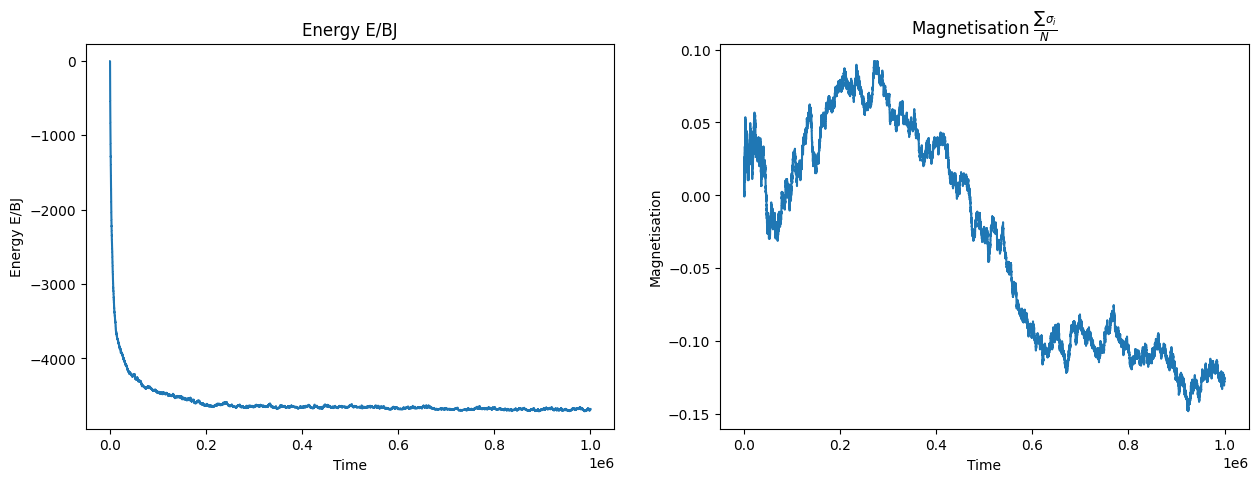

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(range(time), energies);
ax.set_title('Energy E/BJ');
ax.set_xlabel('Time');
ax.set_ylabel('Energy E/BJ');
ax = axes[1]
ax.plot(range(time), magnetisations);
ax.set_title(r'Magnetisation $\frac{\sum{\sigma_i}}{N}$');
ax.set_xlabel('Time');
ax.set_ylabel('Magnetisation');

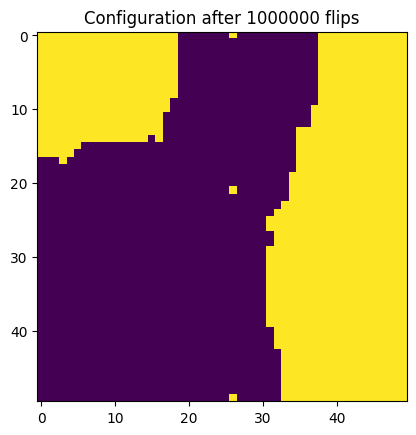

In [40]:
plt.imshow(lattice);
plt.title(f'Configuration after {time} flips');